In [59]:
import sys

print(sys.executable)
# !{sys.executable} -m pip install ase
# !{sys.executable} -m pip install tk
import tkinter

print(tkinter.Tcl().eval("info patchlevel"))

# !{sys.executable} -m pip install ipywidgets-jsonschema

/Users/mat3ra/.pyenv/versions/3.11.4/bin/python
8.6.13


In [60]:
from ipywidgets_jsonschema import Form

inputs_schema = {
    "$schema": "http://json-schema.org/draft-07/schema#",
    "type": "object",
    "properties": {
        "slab": {
            "type": "object",
            "properties": {
                "miller:h": {"type": "integer", "default": 1},
                "miller:k": {"type": "integer", "default": 1},
                "miller:l": {"type": "integer", "default": 1},
                "vacuum_ratio": {"type": "number", "default": 0.5},
                "number_of_layers": {"type": "integer", "default": 3},
            },
            "required": ["miller:h", "miller:k", "miller:l", "vacuum_ratio", "number_of_layers"],
        },
        "interface": {
            "type": "object",
            "properties": {
                "slab_v:matrix": {
                    "type": "array",
                    "items": {"type": "array", "items": {"type": "integer"}, "minItems": 2, "maxItems": 2},
                    "minItems": 2,
                    "maxItems": 2,
                    "default": [[1, 0], [0, 1]],
                },
                "layer_v:matrix": {
                    "type": "array",
                    "items": {"type": "array", "items": {"type": "integer"}, "minItems": 2, "maxItems": 2},
                    "minItems": 2,
                    "maxItems": 2,
                    "default": [[1, 0], [0, 1]],
                },
                "distance": {"type": "number", "default": 2.0},
            },
            "required": ["slab_v:matrix", "layer_v:matrix", "distance"],
        },
    },
    "required": ["slab", "interface"],
}


form = Form(inputs_schema)

In [61]:
# data that comes from JS, here are some examples
poscars = {
    "Ni": """Ni4
1.0
   3.4751458659480110    0.0000000000000000    0.0000000000000002
   0.0000000000000006    3.4751458659480110    0.0000000000000002
   0.0000000000000000    0.0000000000000000    3.4751458659480110
Ni
4
direct
   0.0000000000000000    0.0000000000000000    0.0000000000000000 Ni
   0.0000000000000000    0.5000000000000000    0.5000000000000000 Ni
   0.5000000000000000    0.0000000000000000    0.5000000000000000 Ni
   0.5000000000000000    0.5000000000000000    0.0000000000000000 Ni
""",
    "Cu": """Cu4
1.0
   3.5774306715697510    0.0000000000000000    0.0000000000000002
   0.0000000000000006    3.5774306715697510    0.0000000000000002
   0.0000000000000000    0.0000000000000000    3.5774306715697510
Cu
4
direct
   0.0000000000000000    0.0000000000000000    0.0000000000000000 Cu
   0.0000000000000000    0.5000000000000000    0.5000000000000000 Cu
   0.5000000000000000    0.0000000000000000    0.5000000000000000 Cu
   0.5000000000000000    0.5000000000000000    0.0000000000000000 Cu
""",
    "Au": """Au4
1.0
   4.1712885314747270    0.0000000000000000    0.0000000000000003
   0.0000000000000007    4.1712885314747270    0.0000000000000003
   0.0000000000000000    0.0000000000000000    4.1712885314747270
Au
4
direct
   0.0000000000000000    0.0000000000000000    0.0000000000000000 Au
   0.0000000000000000    0.5000000000000000    0.5000000000000000 Au
   0.5000000000000000    0.0000000000000000    0.5000000000000000 Au
   0.5000000000000000    0.5000000000000000    0.0000000000000000 Au
""",
    "SiC": """Si4 C4
1.0
   4.3539932475828609    0.0000000000000000    0.0000000000000003
   0.0000000000000007    4.3539932475828609    0.0000000000000003
   0.0000000000000000    0.0000000000000000    4.3539932475828609
Si C
4 4
direct
   0.7500000000000000    0.2500000000000000    0.7500000000000000 Si4+
   0.7500000000000000    0.7500000000000000    0.2500000000000000 Si4+
   0.2500000000000000    0.2500000000000000    0.2500000000000000 Si4+
   0.2500000000000000    0.7500000000000000    0.7500000000000000 Si4+
   0.0000000000000000    0.0000000000000000    0.0000000000000000 C4-
   0.0000000000000000    0.5000000000000000    0.5000000000000000 C4-
   0.5000000000000000    0.0000000000000000    0.5000000000000000 C4-
   0.5000000000000000    0.5000000000000000    0.0000000000000000 C4-
""",
    "Graphene": """Graphene
1.0
   2.467291000	   0.000000000	   0.000000000
  -1.233645000	   2.136737000	   0.000000000
   0.000000000	   0.000000000	   7.803074000
C
2
direct
   0.000000000    0.000000000    0.000000000  C
   0.333333000    0.666667000    0.000000000  C
""",
}

In [131]:
# definition of MaterialInterface class
from ase import Atoms
from ase.build import surface, supercells
from ase.io import read, write
from ase.visualize import view
import io
from operator import itemgetter
import numpy as np


def poscar_to_atoms(poscar):
    input = io.StringIO(poscar)
    atoms = read(input, format="vasp")
    return atoms


def write_atoms_to_poscar(atoms):
    output = io.StringIO()
    write(output, atoms, format="vasp")
    content = output.getvalue()
    output.close()
    return content


def poscar_to_cif(poscar):
    input = io.StringIO(poscar)
    atoms = read(input, format="vasp")

    output = io.BytesIO()
    write(output, atoms, format="cif")
    content = output.getvalue()
    output.close()
    return content


def expand_matrix_2x2_to_3x3(matrix_2x2):
    matrix_3x3 = [[0, 0, 0], [0, 0, 0], [0, 0, 1]]

    for i in range(2):
        for j in range(2):
            matrix_3x3[i][j] = matrix_2x2[i][j]

    return matrix_3x3


class MaterialInterface:
    def __init__(self, substrate, material, settings=None):
        self.substrate = substrate
        self.material = material
        self.settings = globals()["default_settings"]
        if settings:
            for key in self.settings.keys():
                if key in settings:
                    self.settings[key].update(settings[key])
        self.structure = self.create_structure()

    def create_structure(self):
        slab = self.settings["slab"]
        interface = self.settings["interface"]

        self.substrate = surface(
            self.substrate,
            (slab["miller:h"], slab["miller:k"], slab["miller:l"]),
            vacuum=slab["vacuum_ratio"],
            layers=slab["number_of_layers"],
        )

        slab_v_matrix = expand_matrix_2x2_to_3x3(interface["slab_v:matrix"])
        layer_v_matrix = expand_matrix_2x2_to_3x3(interface["layer_v:matrix"])

        self.substrate = supercells.make_supercell(self.substrate, slab_v_matrix)
        self.material = supercells.make_supercell(self.material, layer_v_matrix)
        self.original_material = self.material.copy()
        self.material.set_cell(self.substrate.cell, scale_atoms=True)
        self.material.wrap()

        z_max_substrate = max(self.substrate.positions[:, 2])
        z_min_material = min(self.material.positions[:, 2])
        z_offset = z_max_substrate - z_min_material + interface["distance"]
        self.material.positions[:, 2] += z_offset

        return self.substrate + self.material

    def calculate_strain(self, substrate, material):
        """Calculates strain for the material layer on the substrate"""

        substrate_cell = substrate.get_cell()
        material_cell = material.get_cell()

        a0 = np.linalg.norm(substrate_cell[0])
        b0 = np.linalg.norm(substrate_cell[1])

        a1 = np.linalg.norm(material_cell[0])
        b1 = np.linalg.norm(material_cell[1])

        strain_a = (a1 - a0) / a0
        strain_b = (b1 - b0) / b0

        return (strain_a, strain_b)

    def view(self):
        view(self.structure * [3, 3, 1])

In [75]:
form.show(width="300px")
print(form.data)

{'slab': {'miller:h': 1, 'miller:k': 0, 'miller:l': 0, 'vacuum_ratio': 0.5, 'number_of_layers': 3}, 'interface': {'slab_v:matrix': [[3, 0], [0, 3]], 'layer_v:matrix': [[6, 2], [2, 6]], 'distance': 2.0}}


In [102]:
# actual Pyodide code

global settings, poscar_data
settings = form.data
poscar_data = poscars


def func():
    """This function is a gateway to Pyodide in Materials Designer"""

    poscar_data = globals()["poscar_data"]
    settings = globals()["settings"]
    materials = {}

    for material_name, poscar in poscar_data.items():
        materials[material_name] = poscar_to_atoms(poscar)

    interface = MaterialInterface(materials["SiC"], materials["Graphene"], settings)
    write("structure.poscar", interface.structure, format="vasp")

    view(interface.structure)
    print("strain (a, b):", interface.calculate_strain())


func()

TypeError: MaterialInterface.calculate_strain() missing 2 required positional arguments: 'substrate' and 'material'

In [103]:
form.show(width="300px")

In [112]:
settings = form.data

interface2 = MaterialInterface(poscar_to_atoms(poscars["Au"]), poscar_to_atoms(poscars["Graphene"]), settings)
print(interface2.structure)
print(interface2.calculate_strain(interface2.substrate, interface2.original_material))
interface2.view()

LinAlgError: Singular matrix

In [67]:
# interface_master from a paper by Yaoshu Xiea, Kiyou Shibataa and Teruyasu Miozguchia
# https://github.com/nmdl-mizo/interface_master/tree/develop

import sys

# !{sys.executable} -m pip install git+https://github.com/nmdl-mizo/interface_master

In [132]:
def get_settings(prefix="slab", max_v=2):
    settings_array = []
    for v1 in range(0, max_v):
        for v2 in range(0, max_v):
            for u1 in range(0, max_v):
                for u2 in range(0, max_v):
                    matrix = [[v1, v2], [u1, u2]]
                    if np.linalg.det(matrix) > 0:
                        settings_array.append({"interface": {f"{prefix}_v:matrix": matrix}})
    return settings_array


def brute_force_optimization(substrate, material, max_v=10):
    strain = []
    settings_slab = get_settings()
    settings_material = get_settings(prefix="layer")
    for settings in settings_slab:
        for settings2 in settings_material:
            settings["interface"].update(settings2["interface"])
            interface = MaterialInterface(substrate, material, settings)
            s = interface.calculate_strain(interface.substrate, interface.original_material)
            strain.append({"strain": s, "settings": settings, "metric": s[0] * s[0] + s[1] * s[1]})
    return strain


data = brute_force_optimization(poscar_to_atoms(poscars["Au"]), poscar_to_atoms(poscars["Graphene"]))
print(data)
# sort by metric
data = sorted(data, key=itemgetter("metric"))
print(data)

{'interface': {'slab_v:matrix': [[1, 0], [0, 1]], 'layer_v:matrix': [[1, 0], [0, 1]]}}
{'interface': {'slab_v:matrix': [[1, 0], [0, 1]], 'layer_v:matrix': [[1, 0], [0, 2]]}}
{'interface': {'slab_v:matrix': [[1, 0], [0, 1]], 'layer_v:matrix': [[1, 0], [0, 3]]}}
{'interface': {'slab_v:matrix': [[1, 0], [0, 1]], 'layer_v:matrix': [[1, 0], [1, 1]]}}
{'interface': {'slab_v:matrix': [[1, 0], [0, 1]], 'layer_v:matrix': [[1, 0], [1, 2]]}}
{'interface': {'slab_v:matrix': [[1, 0], [0, 1]], 'layer_v:matrix': [[1, 0], [1, 3]]}}
{'interface': {'slab_v:matrix': [[1, 0], [0, 1]], 'layer_v:matrix': [[1, 0], [2, 1]]}}
{'interface': {'slab_v:matrix': [[1, 0], [0, 1]], 'layer_v:matrix': [[1, 0], [2, 2]]}}
{'interface': {'slab_v:matrix': [[1, 0], [0, 1]], 'layer_v:matrix': [[1, 0], [2, 3]]}}
{'interface': {'slab_v:matrix': [[1, 0], [0, 1]], 'layer_v:matrix': [[1, 0], [3, 1]]}}
{'interface': {'slab_v:matrix': [[1, 0], [0, 1]], 'layer_v:matrix': [[1, 0], [3, 2]]}}
{'interface': {'slab_v:matrix': [[1, 0], [0

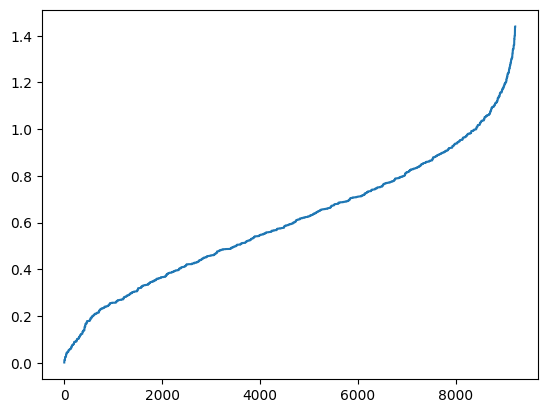

In [133]:
import matplotlib.pyplot as plt

metric = np.array([d["metric"] for d in data])

plt.plot(metric)

interface = MaterialInterface(poscar_to_atoms(poscars["Au"]), poscar_to_atoms(poscars["Graphene"]), data[0]["settings"])
interface.view()